In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import imageio
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import scipy.ndimage as nd

import i3d
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3545822093399954890
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7919681536
locality {
  bus_id: 1
}
incarnation: 12612113000223621934
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


In [2]:
"""
Build Joint Stream Graph (from i3d.py)
"""
_IMAGE_SIZE = 224
_NUM_CLASSES = 400

_SAMPLE_VIDEO_FRAMES = 25
_SAMPLE_PATHS = {
    'rgb': 'data/v_CricketShot_g04_c01_rgb.npy',
    'flow': 'data/v_CricketShot_g04_c01_flow.npy',
}

_CHECKPOINT_PATHS = {
    'rgb': 'data/checkpoints/rgb_scratch/model.ckpt',
    'flow': 'data/checkpoints/flow_scratch/model.ckpt',
    'rgb_imagenet': 'data/checkpoints/rgb_imagenet/model.ckpt',
    'flow_imagenet': 'data/checkpoints/flow_imagenet/model.ckpt',
}

_LABEL_MAP_PATH = 'data/label_map.txt'



imagenet_pretrained = True # use pretrained model as it had better performance
eval_type = "joint" # build the graph for both streams 
tf.reset_default_graph() # reset graph each time cell is run, prevents duplicate variables

if eval_type not in ['rgb', 'flow', 'joint']:
    raise ValueError('Bad `eval_type`, must be one of rgb, flow, joint')

kinetics_classes = [x.strip() for x in open(_LABEL_MAP_PATH)]

if eval_type in ['rgb', 'joint']:
    # RGB input has 3 channels.
    rgb_input = tf.placeholder(
        tf.float32,
        shape=(1, None, _IMAGE_SIZE, _IMAGE_SIZE, 3))
    with tf.variable_scope('RGB'):
        rgb_model = i3d.InceptionI3d(
            _NUM_CLASSES, spatial_squeeze=True, final_endpoint='Logits')
        rgb_logits, _ = rgb_model(
            rgb_input, is_training=False, dropout_keep_prob=1.0)
    rgb_variable_map = {}
    for variable in tf.global_variables():
        if variable.name.split('/')[0] == 'RGB':
            rgb_variable_map[variable.name.replace(':0', '')] = variable
    rgb_saver = tf.train.Saver(var_list=rgb_variable_map, reshape=True)

if eval_type in ['flow', 'joint']:
    # Flow input has only 2 channels.
    flow_input = tf.placeholder(
        tf.float32,
        shape=(1, None, _IMAGE_SIZE, _IMAGE_SIZE, 2))
    with tf.variable_scope('Flow'):
        flow_model = i3d.InceptionI3d(
            _NUM_CLASSES, spatial_squeeze=True, final_endpoint='Logits')
        flow_logits, _ = flow_model(
            flow_input, is_training=False, dropout_keep_prob=1.0)
    flow_variable_map = {}
    for variable in tf.global_variables():
        if variable.name.split('/')[0] == 'Flow':
            flow_variable_map[variable.name.replace(':0', '')] = variable
    flow_saver = tf.train.Saver(var_list=flow_variable_map, reshape=True)

if eval_type == 'rgb':
    model_logits = rgb_logits
elif eval_type == 'flow':
    model_logits = flow_logits
else:
    model_logits = rgb_logits + flow_logits
model_predictions = tf.nn.softmax(model_logits)

In [3]:
"""
Run sample (playing cricket) prediction with joint
"""
eval_type = "joint"
with tf.Session() as sess:
        feed_dict = {}
        if eval_type in ['rgb', 'joint']:
            if imagenet_pretrained:
                rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb_imagenet'])
            else:
                rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb'])
            tf.logging.info('RGB checkpoint restored')
            rgb_sample = np.load(_SAMPLE_PATHS['rgb'])
            print("RGB size:", rgb_sample.shape)
            tf.logging.info('RGB data loaded, shape=%s', str(rgb_sample.shape))
            feed_dict[rgb_input] = rgb_sample

        if eval_type in ['flow', 'joint']:
            if imagenet_pretrained:
                flow_saver.restore(sess, _CHECKPOINT_PATHS['flow_imagenet'])
            else:
                flow_saver.restore(sess, _CHECKPOINT_PATHS['flow'])
            tf.logging.info('Flow checkpoint restored')
            flow_sample = np.load(_SAMPLE_PATHS['flow'])
            print("flow size:", flow_sample.shape)
            tf.logging.info('Flow data loaded, shape=%s',
                            str(flow_sample.shape))
            feed_dict[flow_input] = flow_sample
        # print("feed_dict", feed_dict)
        out_logits, out_predictions = sess.run(
            [model_logits, model_predictions],
            feed_dict=feed_dict)

        out_logits = out_logits[0]
        out_predictions = out_predictions[0]
        sorted_indices = np.argsort(out_predictions)[::-1]

        print('Norm of logits: %f' % np.linalg.norm(out_logits))
        print('\nTop classes and probabilities')
        for index in sorted_indices[:20]:
            print(out_predictions[index], out_logits[
                  index], kinetics_classes[index])

INFO:tensorflow:Restoring parameters from data/checkpoints/rgb_imagenet/model.ckpt
INFO:tensorflow:RGB checkpoint restored
RGB size: (1, 79, 224, 224, 3)
INFO:tensorflow:RGB data loaded, shape=(1, 79, 224, 224, 3)
INFO:tensorflow:Restoring parameters from data/checkpoints/flow_imagenet/model.ckpt
INFO:tensorflow:Flow checkpoint restored
flow size: (1, 79, 224, 224, 2)
INFO:tensorflow:Flow data loaded, shape=(1, 79, 224, 224, 2)
Norm of logits: 138.468658

Top classes and probabilities
1.0 41.813683 playing cricket
1.497162e-09 21.493988 hurling (sport)
3.8430797e-10 20.134106 catching or throwing baseball
1.54923e-10 19.22559 catching or throwing softball
1.1360122e-10 18.915356 hitting baseball
8.801088e-11 18.660122 playing tennis
2.4415324e-11 17.377872 playing kickball
1.153184e-11 16.627773 playing squash or racquetball
6.1318776e-12 15.996161 shooting goal (soccer)
4.391727e-12 15.662384 hammer throw
2.2134183e-12 14.9772 golf putting
1.6307032e-12 14.671674 throwing discus
1.545

In [4]:
from scipy.ndimage.filters import gaussian_filter1d
def blur_image(X, sigma=1):
    # start = time.time()
    X = gaussian_filter1d(X, sigma, axis=1)
    X = gaussian_filter1d(X, sigma, axis=2)
    X = gaussian_filter1d(X, sigma, axis=3)
    # print("Blur time", time.time()-start)
    return X


def create_flow_image(X):
        return np.append(X + 0.5, 0.5 * np.ones((224, 224, 1)), axis=2)


def save_gif(X, class_name, stream_type):
    # save all frames
    num_frames = X.shape[1]
    directory = "experiments_{}/{}/".format(stream_type, class_name)
    if not os.path.exists(directory):
        os.makedirs(directory)
    image_name = "{}_{}".format(class_name, stream_type)
    file_name = directory + image_name + "{}.png"
    print("file_name", file_name)
    filenames = []
    for i in range(0, num_frames):
        if stream_type == "rgb":
            plt.imshow(X[0][i])
        elif stream_type == "flow":
            plt.imshow(create_flow_image(X[0][i]))
        
        filename = file_name.format(i)
        filenames.append(filename)
        plt.savefig(filename.format(i))
        # plt.show()
    
    #create gif
    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
        imageio.mimsave(directory + "/{}".format(image_name) + ".gif", images)

def calc_sigma(curr, total, sigma):
    if curr > .75*total:
        return sigma
    
    elif curr > .5*total:
        return .75*sigma 
    
    elif curr > .25*total:
        return .5*sigma
    
    else:
        return .25*sigma
    
def crop_center(img, cropx, cropy):
    y, x, channels = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)
    return img[starty:starty+cropy, startx:startx+cropx, :]

def scale_and_crop(X, scale=1.2):
    start = time.time()
    _, frames, cropx, cropy, channels = X.shape
    for i in range(frames):
        Y = X[0][i]
        Y = nd.zoom(Y, (scale, scale, 1))
        Y = crop_center(Y, cropx, cropy)
        X[0][i] = Y
    print("time for 25 frames 3d", time.time() - start)

In [5]:
def create_class_visualization(sess, rgb_input, flow_input, target_y, logits, class_name, **kwargs):
    """
    Keyword arguments:
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to gjitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """
    print("params", kwargs)
    l2_reg = kwargs.pop('l2_reg', 1e-3)
    learning_rate = kwargs.pop('learning_rate', 25)
    num_iterations = kwargs.pop('num_iterations', 100)
    blur_every = kwargs.pop('blur_every', 4)
    max_jitter = kwargs.pop('max_jitter', 16)
    show_every = kwargs.pop('show_every', 25)
    num_frames = kwargs.pop('num_frames', 25)
    stream_type = kwargs.pop('stream_type', 'rgb')
    sigma_start = kwargs.pop('sigma', 1)
    
    # X = np.random.rand(num_frames, 224, 224, 3)
    if stream_type == 'rgb':
        stream_input = rgb_input
        X = np.random.rand(1, 224, 224, 3) * np.ones((num_frames, 224, 224, 3))
        X = X[None]
    elif stream_type == 'flow':
        stream_input = flow_input
        # may need to change noise instiantiation
        X = np.random.rand(1, 224, 224, 2) * np.ones((num_frames, 224, 224, 2))
        # preprocess as described in paper
        X = X - .5
        X = X[None]
        X = flow_sample
    
    loss = logits[0, target_y] # scalar loss

    grad = tf.gradients(loss, stream_input) # compute gradient
    grad = tf.squeeze(grad) - l2_reg*2*stream_input # regualarlize gradient

    start_time = time.time()
    for t in range(num_iterations):
        
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = np.random.randint(-max_jitter, max_jitter+1, 2)
        Xi = X.copy()
        X = np.roll(np.roll(X, ox, 1), oy, 2)

        # we want logits for loss, model.classifier are just logits
        loss = logits[0, target_y] # scalar loss

        # model.image is just the data matrix input (a gif in our case)
        gradient_step = sess.run(grad, feed_dict={stream_input:X})
        X += learning_rate * gradient_step

        # Undo the jitter
        X = np.roll(np.roll(X, -ox, 1), -oy, 2)

        # As a regularizer, clip and periodically blur
        if stream_type == 'flow':
            X = np.clip(X, -0.5, 0.5)
        elif stream_type == 'rgb':
            X = np.clip(X, 0, 1)
        
        if t % blur_every == 0 or t == num_iterations - 1:
            # sigma = calc_sigma(t, num_iterations, sigma_start)
            X = blur_image(X, sigma=sigma_start)
            
        if t % 250 == 0:
            scale_and_crop(X)
        
        print("iteration:", t, time.time()-start_time)
        
        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            
            if stream_type == "rgb":
                plt.imshow(X[0][0])
            elif stream_type == "flow":
                plt.imshow(create_flow_image(X[0][0]))
          
            if t == num_iterations-1:
                save_gif(X, class_name, stream_type)
                    
            plt.title('{}_{}\nIteration {} / {}'.format(class_name, stream_type, t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis('off')
            plt.show()
        
    return X

Tensor("add:0", shape=(1, 400), dtype=float32)
Tensor("Placeholder:0", shape=(1, ?, 224, 224, 3), dtype=float32)
swimming breast stroke
INFO:tensorflow:Restoring parameters from data/checkpoints/rgb_imagenet/model.ckpt
params {'max_jitter': 32, 'blur_every': 3, 'num_iterations': 1000, 'learning_rate': 1.5, 'num_frames': 25, 'stream_type': 'rgb'}


/home/willsong/kinetics-i3d/local/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


time for 25 frames 3d 2.66551804543
iteration: 0 6.04814696312


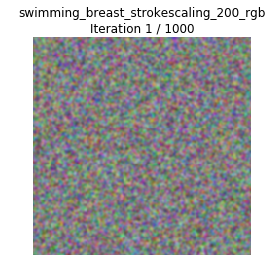

iteration: 1 6.36473798752
iteration: 2 6.58670687675
iteration: 3 7.02934098244
iteration: 4 7.2536239624
iteration: 5 7.46223402023
iteration: 6 7.81943798065
iteration: 7 8.06199884415
iteration: 8 8.3421330452
iteration: 9 8.77223992348
iteration: 10 8.99878787994
iteration: 11 9.23485898972
iteration: 12 9.56929802895
iteration: 13 9.78649306297
iteration: 14 10.0238959789
iteration: 15 10.406359911
iteration: 16 10.6259820461
iteration: 17 10.8476979733
iteration: 18 11.1818869114
iteration: 19 11.3945720196
iteration: 20 11.6348400116
iteration: 21 12.0242569447
iteration: 22 12.2422919273
iteration: 23 12.4601290226
iteration: 24 12.8342409134


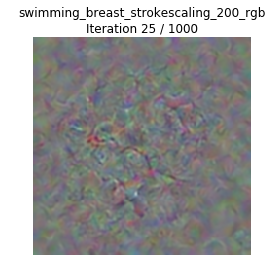

iteration: 25 13.1720018387
iteration: 26 13.3881099224
iteration: 27 13.701048851
iteration: 28 13.9186329842
iteration: 29 14.1557269096
iteration: 30 14.4935948849
iteration: 31 14.7125928402
iteration: 32 14.9595038891
iteration: 33 15.3618869781
iteration: 34 15.5872590542
iteration: 35 15.8328340054
iteration: 36 16.2418539524
iteration: 37 16.4678308964
iteration: 38 16.7138538361
iteration: 39 17.1093900204
iteration: 40 17.330988884
iteration: 41 17.5831408501
iteration: 42 17.9917609692
iteration: 43 18.2178509235
iteration: 44 18.4660758972
iteration: 45 18.8150339127
iteration: 46 19.0427808762
iteration: 47 19.3195340633
iteration: 48 19.7541229725
iteration: 49 19.9825980663


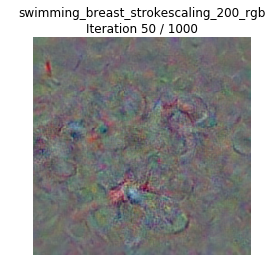

iteration: 50 20.3428020477
iteration: 51 20.7274289131
iteration: 52 20.9459478855
iteration: 53 21.1615350246
iteration: 54 21.5050559044
iteration: 55 21.7254099846
iteration: 56 21.9694318771
iteration: 57 22.3112568855
iteration: 58 22.533575058
iteration: 59 22.7788059711
iteration: 60 23.1965918541
iteration: 61 23.4243319035
iteration: 62 23.652271986
iteration: 63 24.0317020416
iteration: 64 24.2561929226
iteration: 65 24.4774549007
iteration: 66 24.864333868
iteration: 67 25.0878949165
iteration: 68 25.3192789555
iteration: 69 25.6527819633
iteration: 70 25.8731460571
iteration: 71 26.1135239601
iteration: 72 26.4855139256
iteration: 73 26.7089109421
iteration: 74 26.959941864


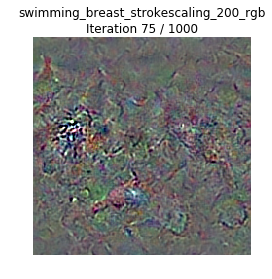

iteration: 75 27.4490869045
iteration: 76 27.6723818779
iteration: 77 27.9118359089
iteration: 78 28.2235269547
iteration: 79 28.438560009
iteration: 80 28.6578199863
iteration: 81 28.9730558395
iteration: 82 29.189483881
iteration: 83 29.4051828384
iteration: 84 29.7334780693
iteration: 85 29.9485549927
iteration: 86 30.1646828651
iteration: 87 30.5039608479
iteration: 88 30.721683979
iteration: 89 30.9406459332
iteration: 90 31.2744729519
iteration: 91 31.5095820427
iteration: 92 31.7681210041
iteration: 93 32.0889868736
iteration: 94 32.3076200485
iteration: 95 32.5330660343
iteration: 96 32.9200689793
iteration: 97 33.1579039097
iteration: 98 33.407779932
iteration: 99 33.8398199081


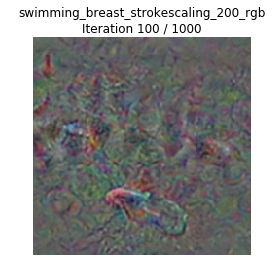

iteration: 100 34.1975579262
iteration: 101 34.4167230129
iteration: 102 34.8028008938
iteration: 103 35.0339610577
iteration: 104 35.2840909958
iteration: 105 35.6543118954
iteration: 106 35.878964901
iteration: 107 36.1261489391
iteration: 108 36.5380990505
iteration: 109 36.7719688416
iteration: 110 37.0334398746
iteration: 111 37.4622118473
iteration: 112 37.6981568336
iteration: 113 37.9341230392
iteration: 114 38.307446003
iteration: 115 38.5283248425
iteration: 116 38.7550959587
iteration: 117 39.0997149944
iteration: 118 39.3345358372
iteration: 119 39.6198139191
iteration: 120 40.0572390556
iteration: 121 40.2860310078
iteration: 122 40.5431659222
iteration: 123 40.9706029892
iteration: 124 41.2056758404


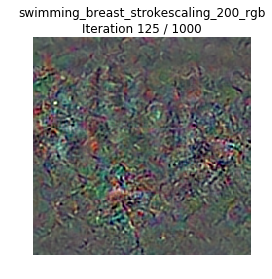

iteration: 125 41.5641448498
iteration: 126 41.937805891
iteration: 127 42.1692860126
iteration: 128 42.4256088734
iteration: 129 42.8497948647
iteration: 130 43.0776090622
iteration: 131 43.3180940151
iteration: 132 43.7160458565
iteration: 133 43.944341898
iteration: 134 44.1890308857
iteration: 135 44.5399649143
iteration: 136 44.7617259026
iteration: 137 45.0119738579
iteration: 138 45.4483649731
iteration: 139 45.6803250313
iteration: 140 45.9287509918
iteration: 141 46.3175749779
iteration: 142 46.5521299839
iteration: 143 46.8234808445
iteration: 144 47.1877360344
iteration: 145 47.4120519161
iteration: 146 47.6544599533
iteration: 147 48.0208129883
iteration: 148 48.2579798698
iteration: 149 48.5419139862


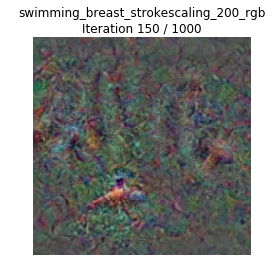

iteration: 150 49.0343599319
iteration: 151 49.2590398788
iteration: 152 49.5187718868
iteration: 153 49.9238610268
iteration: 154 50.163244009
iteration: 155 50.4462690353
iteration: 156 50.8681280613
iteration: 157 51.1200199127
iteration: 158 51.4096188545
iteration: 159 51.8471069336
iteration: 160 52.0803039074
iteration: 161 52.316339016
iteration: 162 52.697521925
iteration: 163 52.9187319279
iteration: 164 53.1428198814
iteration: 165 53.5396368504
iteration: 166 53.7681620121
iteration: 167 54.0144519806
iteration: 168 54.4346690178
iteration: 169 54.6833388805
iteration: 170 54.9736800194
iteration: 171 55.416960001
iteration: 172 55.6491270065
iteration: 173 55.8665339947
iteration: 174 56.1808800697


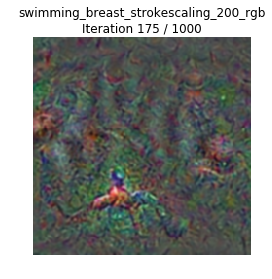

iteration: 175 56.5078389645
iteration: 176 56.7346889973
iteration: 177 57.1072540283
iteration: 178 57.3393838406
iteration: 179 57.5917749405
iteration: 180 57.934910059
iteration: 181 58.1704289913
iteration: 182 58.4602220058
iteration: 183 58.8981359005
iteration: 184 59.1369650364
iteration: 185 59.3901338577
iteration: 186 59.7373380661
iteration: 187 59.9616589546
iteration: 188 60.202837944
iteration: 189 60.6332018375
iteration: 190 60.8759610653
iteration: 191 61.1623768806
iteration: 192 61.5999450684
iteration: 193 61.832201004
iteration: 194 62.0795669556
iteration: 195 62.452491045
iteration: 196 62.6789748669
iteration: 197 62.9250149727
iteration: 198 63.3205618858
iteration: 199 63.5621879101


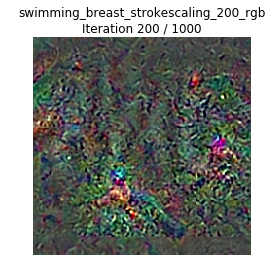

iteration: 200 63.9530990124
iteration: 201 64.3747918606
iteration: 202 64.6123690605
iteration: 203 65.0253789425
iteration: 204 65.4049670696
iteration: 205 65.6418118477
iteration: 206 65.9298598766
iteration: 207 66.3720059395
iteration: 208 66.6125609875
iteration: 209 66.8713159561
iteration: 210 67.2722420692
iteration: 211 67.5128090382
iteration: 212 67.803139925
iteration: 213 68.2412250042
iteration: 214 68.476418972
iteration: 215 68.7290320396
iteration: 216 69.1296029091
iteration: 217 69.3628759384
iteration: 218 69.6198449135
iteration: 219 70.0249249935
iteration: 220 70.2621388435
iteration: 221 70.5139100552
iteration: 222 70.8988220692
iteration: 223 71.1302640438
iteration: 224 71.378813982


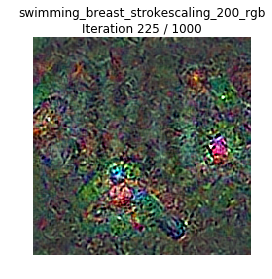

iteration: 225 71.8888888359
iteration: 226 72.1192350388
iteration: 227 72.3784210682
iteration: 228 72.8270070553
iteration: 229 73.0670528412
iteration: 230 73.3354978561
iteration: 231 73.7523138523
iteration: 232 74.0006709099
iteration: 233 74.2732980251
iteration: 234 74.7213499546
iteration: 235 74.9760539532
iteration: 236 75.2725229263
iteration: 237 75.6718449593
iteration: 238 75.9110238552
iteration: 239 76.2009060383
iteration: 240 76.6100208759
iteration: 241 76.8429789543
iteration: 242 77.1045229435
iteration: 243 77.5141448975
iteration: 244 77.7452819347
iteration: 245 77.9898059368
iteration: 246 78.3389868736
iteration: 247 78.5702939034
iteration: 248 78.8293299675
iteration: 249 79.2743299007


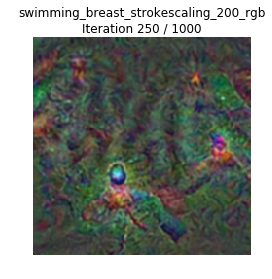

time for 25 frames 3d 2.63209700584
iteration: 250 82.2651238441
iteration: 251 82.4922449589
iteration: 252 82.8413219452
iteration: 253 83.0640778542
iteration: 254 83.3050000668
iteration: 255 83.6984260082
iteration: 256 83.9285650253
iteration: 257 84.1722588539
iteration: 258 84.4926328659
iteration: 259 84.7255790234
iteration: 260 84.9746229649
iteration: 261 85.2987170219
iteration: 262 85.5244119167
iteration: 263 85.7530288696
iteration: 264 86.090875864
iteration: 265 86.3199379444
iteration: 266 86.5704379082
iteration: 267 86.9648900032
iteration: 268 87.1938049793
iteration: 269 87.419123888
iteration: 270 87.7402050495
iteration: 271 87.9698019028
iteration: 272 88.2264258862
iteration: 273 88.6358568668
iteration: 274 88.8744089603


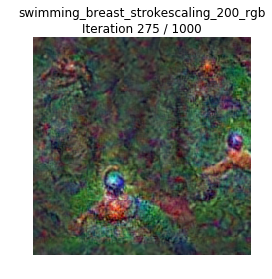

iteration: 275 89.2361528873
iteration: 276 89.6264419556
iteration: 277 89.8732039928
iteration: 278 90.1672170162
iteration: 279 90.5927488804
iteration: 280 90.8311140537
iteration: 281 91.0896170139
iteration: 282 91.5265748501
iteration: 283 91.811524868
iteration: 284 92.111798048
iteration: 285 92.5463750362
iteration: 286 92.7941520214
iteration: 287 93.0623259544
iteration: 288 93.4937119484
iteration: 289 93.7441949844
iteration: 290 94.0400938988
iteration: 291 94.4545829296
iteration: 292 94.6950190067
iteration: 293 94.9550569057
iteration: 294 95.3664450645
iteration: 295 95.6132559776
iteration: 296 95.9013829231
iteration: 297 96.2784118652
iteration: 298 96.5141320229
iteration: 299 96.7858350277


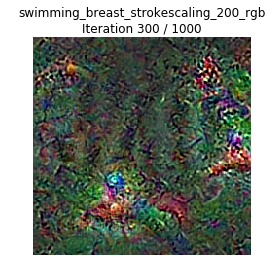

iteration: 300 97.2997229099
iteration: 301 97.5499589443
iteration: 302 97.8392848969
iteration: 303 98.1698930264
iteration: 304 98.4113059044
iteration: 305 98.6998050213
iteration: 306 99.1192669868
iteration: 307 99.3714008331
iteration: 308 99.6677949429
iteration: 309 100.088310003
iteration: 310 100.342190981
iteration: 311 100.644222975
iteration: 312 101.089657068
iteration: 313 101.330600977
iteration: 314 101.590260029
iteration: 315 101.995471001
iteration: 316 102.236530066
iteration: 317 102.519865036
iteration: 318 102.934923887
iteration: 319 103.171757936
iteration: 320 103.427762985
iteration: 321 103.87270689
iteration: 322 104.112499952
iteration: 323 104.36417985
iteration: 324 104.779896975


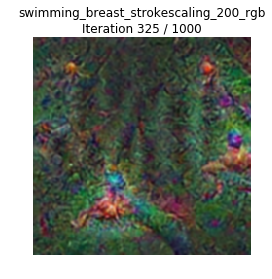

iteration: 325 105.128026962
iteration: 326 105.381707907
iteration: 327 105.777863026
iteration: 328 106.018996
iteration: 329 106.286345005
iteration: 330 106.721755981
iteration: 331 106.964751959
iteration: 332 107.209748983
iteration: 333 107.651958942
iteration: 334 107.892575026
iteration: 335 108.150418997
iteration: 336 108.514046907
iteration: 337 108.746402025
iteration: 338 109.012264967
iteration: 339 109.469373941
iteration: 340 109.71875
iteration: 341 109.992296934
iteration: 342 110.392371893
iteration: 343 110.63331604
iteration: 344 110.88961792
iteration: 345 111.321123838
iteration: 346 111.569758892
iteration: 347 111.831415892
iteration: 348 112.24078989
iteration: 349 112.481807947


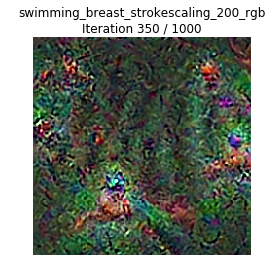

iteration: 350 112.917666912
iteration: 351 113.371989012
iteration: 352 113.631088972
iteration: 353 113.937962055
iteration: 354 114.366761923
iteration: 355 114.617872
iteration: 356 114.912238836
iteration: 357 115.320546865
iteration: 358 115.560373068
iteration: 359 115.825515032
iteration: 360 116.228037834
iteration: 361 116.466662884
iteration: 362 116.727453947
iteration: 363 117.114547968
iteration: 364 117.363168001
iteration: 365 117.669183969
iteration: 366 118.093494892
iteration: 367 118.333715916
iteration: 368 118.573771954
iteration: 369 118.922451019
iteration: 370 119.165621042
iteration: 371 119.475522041
iteration: 372 119.902034044
iteration: 373 120.148241997
iteration: 374 120.450715065


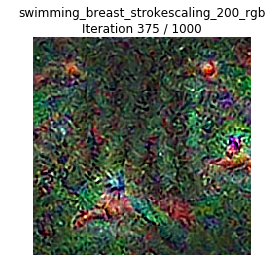

iteration: 375 120.980737925
iteration: 376 121.2248559
iteration: 377 121.525825977
iteration: 378 121.999757051
iteration: 379 122.237943888
iteration: 380 122.501215935
iteration: 381 122.871924877
iteration: 382 123.113846064
iteration: 383 123.383127928
iteration: 384 123.818171024
iteration: 385 124.065997839
iteration: 386 124.329189062
iteration: 387 124.762004852
iteration: 388 125.019208908
iteration: 389 125.310605049
iteration: 390 125.717821836
iteration: 391 125.979475975
iteration: 392 126.279116869
iteration: 393 126.737448931
iteration: 394 126.993602991
iteration: 395 127.264729977
iteration: 396 127.66461587
iteration: 397 127.924829006
iteration: 398 128.227016926
iteration: 399 128.670021057


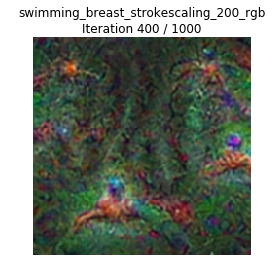

iteration: 400 129.098520041
iteration: 401 129.39218998
iteration: 402 129.846214056
iteration: 403 130.087842941
iteration: 404 130.325180054
iteration: 405 130.721328974
iteration: 406 130.966791868
iteration: 407 131.263350964
iteration: 408 131.649355888
iteration: 409 131.885350943
iteration: 410 132.146565914
iteration: 411 132.596541882
iteration: 412 132.841681004
iteration: 413 133.103495836
iteration: 414 133.523102045
iteration: 415 133.774771929
iteration: 416 134.054093838
iteration: 417 134.437712908
iteration: 418 134.670603037
iteration: 419 134.936248064
iteration: 420 135.387908936
iteration: 421 135.634790897
iteration: 422 135.903992891
iteration: 423 136.323530912
iteration: 424 136.566868067


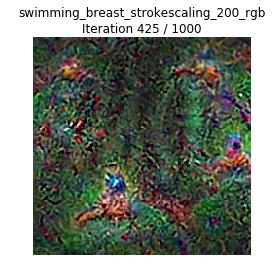

iteration: 425 137.023985863
iteration: 426 137.450088024
iteration: 427 137.691670895
iteration: 428 137.935256004
iteration: 429 138.355108976
iteration: 430 138.604416847
iteration: 431 138.878594875
iteration: 432 139.337646008
iteration: 433 139.592273951
iteration: 434 139.858561039
iteration: 435 140.293386936
iteration: 436 140.542547941
iteration: 437 140.805301905
iteration: 438 141.213047981
iteration: 439 141.458539963
iteration: 440 141.732147932
iteration: 441 142.165775061
iteration: 442 142.418864965
iteration: 443 142.723608971
iteration: 444 143.159924984
iteration: 445 143.406933069
iteration: 446 143.681849003
iteration: 447 144.14555788
iteration: 448 144.394088984
iteration: 449 144.664046049


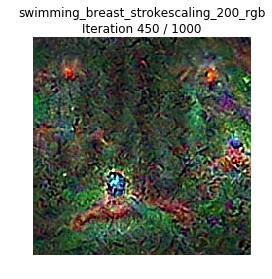

iteration: 450 145.149009943
iteration: 451 145.386714935
iteration: 452 145.636216879
iteration: 453 146.024325848
iteration: 454 146.265048981
iteration: 455 146.54501605
iteration: 456 147.001268864
iteration: 457 147.250299931
iteration: 458 147.508878946
iteration: 459 147.937415838
iteration: 460 148.196326971
iteration: 461 148.499001026
iteration: 462 148.951259851
iteration: 463 149.205729008
iteration: 464 149.472329855
iteration: 465 149.908735991
iteration: 466 150.172561884
iteration: 467 150.474180937
iteration: 468 150.862061024
iteration: 469 151.108525038
iteration: 470 151.402219057
iteration: 471 151.860532999
iteration: 472 152.109416962
iteration: 473 152.372886896
iteration: 474 152.778038025


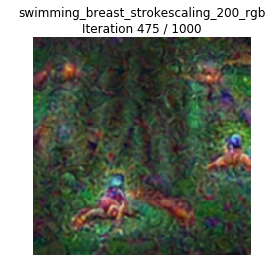

iteration: 475 153.149487019
iteration: 476 153.44965601
iteration: 477 153.887479067
iteration: 478 154.144388914
iteration: 479 154.446383953
iteration: 480 154.901713848
iteration: 481 155.152814865
iteration: 482 155.428879023
iteration: 483 155.838120937
iteration: 484 156.090900898
iteration: 485 156.377742052
iteration: 486 156.841590881
iteration: 487 157.096909046
iteration: 488 157.374619007
iteration: 489 157.821758986
iteration: 490 158.068656921
iteration: 491 158.341855049
iteration: 492 158.740690947
iteration: 493 158.985347033
iteration: 494 159.265423059
iteration: 495 159.699988842
iteration: 496 159.945270061
iteration: 497 160.224577904
iteration: 498 160.666610956
iteration: 499 160.92484498


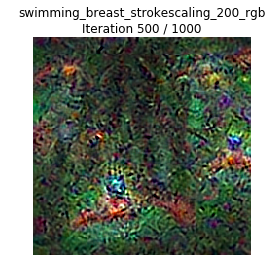

time for 25 frames 3d 2.75936603546
iteration: 500 164.158165932
iteration: 501 164.515225887
iteration: 502 164.757648945
iteration: 503 165.013932943
iteration: 504 165.37825799
iteration: 505 165.620025873
iteration: 506 165.871531963
iteration: 507 166.231752872
iteration: 508 166.472990036
iteration: 509 166.748568058
iteration: 510 167.180103064
iteration: 511 167.43780303
iteration: 512 167.741641045
iteration: 513 168.18727684
iteration: 514 168.43757987
iteration: 515 168.697932005
iteration: 516 169.096124887
iteration: 517 169.354003906
iteration: 518 169.654079914
iteration: 519 170.087179899
iteration: 520 170.340945005
iteration: 521 170.630378962
iteration: 522 171.050588846
iteration: 523 171.344213963
iteration: 524 171.626554966


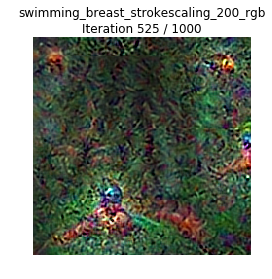

iteration: 525 172.125457048
iteration: 526 172.366719961
iteration: 527 172.646438837
iteration: 528 173.091016054
iteration: 529 173.338252068
iteration: 530 173.581788063
iteration: 531 173.963990927
iteration: 532 174.210114002
iteration: 533 174.481992006
iteration: 534 174.893199921
iteration: 535 175.142802954
iteration: 536 175.414577961
iteration: 537 175.82366991
iteration: 538 176.075877905
iteration: 539 176.337007999
iteration: 540 176.735008955
iteration: 541 176.981492996
iteration: 542 177.245904922
iteration: 543 177.610973835
iteration: 544 177.857692957
iteration: 545 178.136648893
iteration: 546 178.515224934
iteration: 547 178.756980896
iteration: 548 178.999475956
iteration: 549 179.38121891


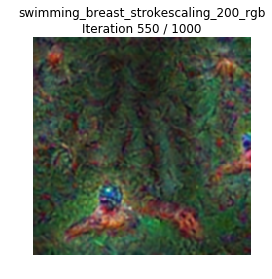

iteration: 550 179.739037037
iteration: 551 180.00356698
iteration: 552 180.348484993
iteration: 553 180.595875025
iteration: 554 180.859315872
iteration: 555 181.247215986
iteration: 556 181.494292021
iteration: 557 181.766641855
iteration: 558 182.202299833
iteration: 559 182.454239845
iteration: 560 182.716384888
iteration: 561 183.088547945
iteration: 562 183.335559845
iteration: 563 183.608968973
iteration: 564 184.017575026
iteration: 565 184.261955976
iteration: 566 184.502014875
iteration: 567 184.851107836
iteration: 568 185.095197916
iteration: 569 185.335571051
iteration: 570 185.700191975
iteration: 571 185.947430849
iteration: 572 186.213834047
iteration: 573 186.619556904
iteration: 574 186.873929024


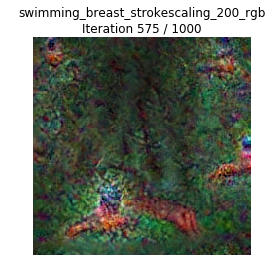

iteration: 575 187.302856922
iteration: 576 187.700518847
iteration: 577 187.9499259
iteration: 578 188.216811895
iteration: 579 188.553714037
iteration: 580 188.799557924
iteration: 581 189.06261301
iteration: 582 189.434087038
iteration: 583 189.684191942
iteration: 584 189.95588088
iteration: 585 190.32080698
iteration: 586 190.567407846
iteration: 587 190.836096048
iteration: 588 191.240671873
iteration: 589 191.490391016
iteration: 590 191.764107943
iteration: 591 192.113117933
iteration: 592 192.348336935
iteration: 593 192.599824905
iteration: 594 192.988903999
iteration: 595 193.231302023
iteration: 596 193.493734837
iteration: 597 193.893684864
iteration: 598 194.14614296
iteration: 599 194.396378994


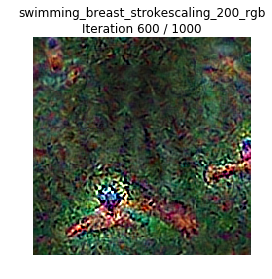

iteration: 600 194.860090971
iteration: 601 195.110378027
iteration: 602 195.377169847
iteration: 603 195.74900198
iteration: 604 195.998631001
iteration: 605 196.27183795
iteration: 606 196.609032869
iteration: 607 196.859230995
iteration: 608 197.115064859
iteration: 609 197.505223989
iteration: 610 197.754145861
iteration: 611 198.021718979
iteration: 612 198.369102001
iteration: 613 198.616263866
iteration: 614 198.864651918
iteration: 615 199.265966892
iteration: 616 199.516690016
iteration: 617 199.786695957
iteration: 618 200.124789
iteration: 619 200.371526957
iteration: 620 200.649061918
iteration: 621 201.056333065
iteration: 622 201.317261934
iteration: 623 201.636015892
iteration: 624 202.095120907


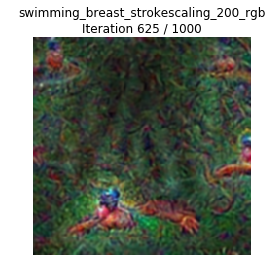

iteration: 625 202.46742487
iteration: 626 202.774134874
iteration: 627 203.128692865
iteration: 628 203.377974987
iteration: 629 203.654718876
iteration: 630 204.118273973
iteration: 631 204.375028849
iteration: 632 204.657935858
iteration: 633 205.118948936
iteration: 634 205.388426065
iteration: 635 205.702414989
iteration: 636 206.167361975
iteration: 637 206.435391903
iteration: 638 206.753430843
iteration: 639 207.210577965
iteration: 640 207.480447054
iteration: 641 207.805696964
iteration: 642 208.29280591
iteration: 643 208.561328888
iteration: 644 208.853600025
iteration: 645 209.312640905
iteration: 646 209.582531929
iteration: 647 209.866914988
iteration: 648 210.317256927
iteration: 649 210.576817036


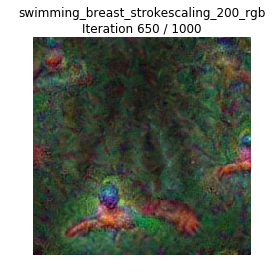

iteration: 650 211.041440964
iteration: 651 211.511307001
iteration: 652 211.780329943
iteration: 653 212.033221006
iteration: 654 212.383779049
iteration: 655 212.635092974
iteration: 656 212.912214041
iteration: 657 213.341117859
iteration: 658 213.59711504
iteration: 659 213.869889021
iteration: 660 214.311707973
iteration: 661 214.574733973
iteration: 662 214.879171848
iteration: 663 215.294101
iteration: 664 215.55764699
iteration: 665 215.829694033
iteration: 666 216.172591925
iteration: 667 216.43460989
iteration: 668 216.75067997
iteration: 669 217.171226978
iteration: 670 217.425490856
iteration: 671 217.685672045
iteration: 672 218.065449953
iteration: 673 218.320379019
iteration: 674 218.591706991


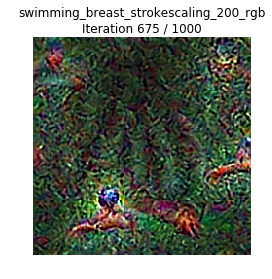

iteration: 675 219.067116022
iteration: 676 219.330200911
iteration: 677 219.642547846
iteration: 678 220.063286066
iteration: 679 220.32900691
iteration: 680 220.644906044
iteration: 681 221.104069948
iteration: 682 221.376803875
iteration: 683 221.692848921
iteration: 684 222.120352983
iteration: 685 222.406236887
iteration: 686 222.68731904
iteration: 687 223.09701705
iteration: 688 223.347985983
iteration: 689 223.620179892
iteration: 690 223.996495962
iteration: 691 224.259526014
iteration: 692 224.549919844
iteration: 693 225.035544872
iteration: 694 225.305081844
iteration: 695 225.588197947
iteration: 696 225.986867905
iteration: 697 226.239048004
iteration: 698 226.498427868
iteration: 699 226.88983798


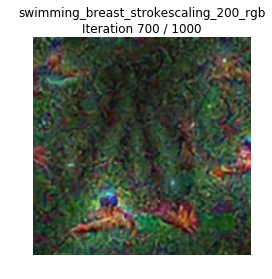

iteration: 700 227.258889914
iteration: 701 227.588660955
iteration: 702 228.019476891
iteration: 703 228.288459063
iteration: 704 228.609904051
iteration: 705 229.041465044
iteration: 706 229.301055908
iteration: 707 229.578477859
iteration: 708 229.959758997
iteration: 709 230.213429928
iteration: 710 230.498337984
iteration: 711 230.91031599
iteration: 712 231.181330919
iteration: 713 231.507834911
iteration: 714 231.984927893
iteration: 715 232.250181913
iteration: 716 232.53956604
iteration: 717 232.954886913
iteration: 718 233.213719845
iteration: 719 233.51264596
iteration: 720 233.976824045
iteration: 721 234.241749048
iteration: 722 234.531264067
iteration: 723 234.976443052
iteration: 724 235.242321968


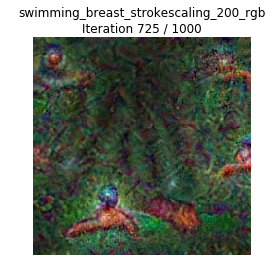

iteration: 725 235.628475904
iteration: 726 236.034487963
iteration: 727 236.307333946
iteration: 728 236.606731892
iteration: 729 237.07347703
iteration: 730 237.33481884
iteration: 731 237.629835844
iteration: 732 238.099379063
iteration: 733 238.371728897
iteration: 734 238.668052912
iteration: 735 239.067993879
iteration: 736 239.334724903
iteration: 737 239.663617849
iteration: 738 240.103296995
iteration: 739 240.362182856
iteration: 740 240.645899057
iteration: 741 241.070960045
iteration: 742 241.330219984
iteration: 743 241.626900911
iteration: 744 242.090224981
iteration: 745 242.361989021
iteration: 746 242.695724964
iteration: 747 243.117464066
iteration: 748 243.386723042
iteration: 749 243.711057901


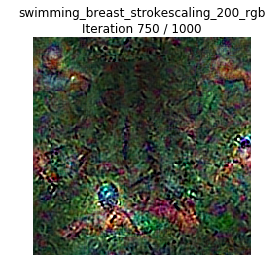

time for 25 frames 3d 2.68146705627
iteration: 750 246.92384696
iteration: 751 247.182963848
iteration: 752 247.502533913
iteration: 753 248.100112915
iteration: 754 248.345432043
iteration: 755 248.625036955
iteration: 756 249.09610796
iteration: 757 249.365129948
iteration: 758 249.648118019
iteration: 759 250.031319857
iteration: 760 250.292898893
iteration: 761 250.557958841
iteration: 762 250.943511009
iteration: 763 251.208199978
iteration: 764 251.496412039
iteration: 765 251.907227039
iteration: 766 252.177960873
iteration: 767 252.46568203
iteration: 768 252.876724005
iteration: 769 253.140475035
iteration: 770 253.429024935
iteration: 771 253.839799881
iteration: 772 254.116652012
iteration: 773 254.459549904
iteration: 774 254.949272871


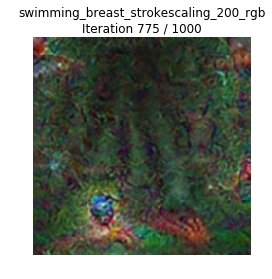

iteration: 775 255.339063883
iteration: 776 255.666429996
iteration: 777 256.082515955
iteration: 778 256.342584848
iteration: 779 256.610580921
iteration: 780 257.020448923
iteration: 781 257.279872894
iteration: 782 257.538145065
iteration: 783 257.924715042
iteration: 784 258.189691067
iteration: 785 258.470794916
iteration: 786 258.861589909
iteration: 787 259.124989986
iteration: 788 259.413591862
iteration: 789 259.825532913
iteration: 790 260.092025995
iteration: 791 260.375725985
iteration: 792 260.765758991
iteration: 793 261.037315845
iteration: 794 261.325003862
iteration: 795 261.681836843
iteration: 796 261.941256046
iteration: 797 262.227880955
iteration: 798 262.633074045
iteration: 799 262.891568899


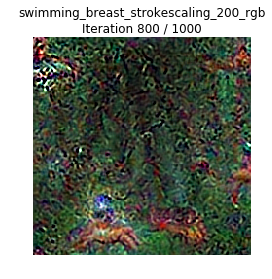

iteration: 800 263.279316902
iteration: 801 263.738313913
iteration: 802 264.006572008
iteration: 803 264.293267012
iteration: 804 264.670773983
iteration: 805 264.935039997
iteration: 806 265.235108852
iteration: 807 265.706830025
iteration: 808 265.986165047
iteration: 809 266.282320023
iteration: 810 266.697021961
iteration: 811 266.975025892
iteration: 812 267.274978876
iteration: 813 267.741338968
iteration: 814 268.018967867
iteration: 815 268.352557898
iteration: 816 268.818493843
iteration: 817 269.088288069
iteration: 818 269.362597942
iteration: 819 269.788522005
iteration: 820 270.065526009
iteration: 821 270.356221914
iteration: 822 270.735560894
iteration: 823 271.002436876
iteration: 824 271.306956053


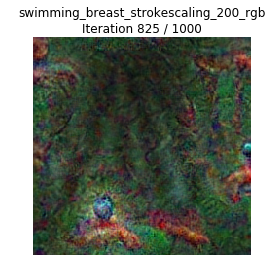

iteration: 825 271.861683846
iteration: 826 272.136632919
iteration: 827 272.42918992
iteration: 828 272.839370012
iteration: 829 273.116921902
iteration: 830 273.451524019
iteration: 831 273.914605856
iteration: 832 274.179715872
iteration: 833 274.463628054
iteration: 834 274.852162838
iteration: 835 275.118676901
iteration: 836 275.397812843
iteration: 837 275.833348989
iteration: 838 276.108788013
iteration: 839 276.389621973
iteration: 840 276.808974981
iteration: 841 277.07375598
iteration: 842 277.354470015
iteration: 843 277.802626848
iteration: 844 278.073035002
iteration: 845 278.337764978
iteration: 846 278.753867865
iteration: 847 279.023416996
iteration: 848 279.325950861
iteration: 849 279.820032835


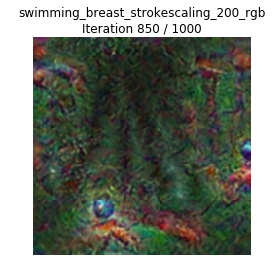

iteration: 850 280.231559992
iteration: 851 280.535052061
iteration: 852 281.036107063
iteration: 853 281.306613922
iteration: 854 281.581632853
iteration: 855 281.993063927
iteration: 856 282.275979996
iteration: 857 282.543971062
iteration: 858 282.960368872
iteration: 859 283.278183937
iteration: 860 283.552052975
iteration: 861 283.935636044
iteration: 862 284.197522879
iteration: 863 284.47515893
iteration: 864 284.943587065
iteration: 865 285.222476006
iteration: 866 285.547865868
iteration: 867 286.018558979
iteration: 868 286.376044989
iteration: 869 286.659045935
iteration: 870 287.071164846
iteration: 871 287.34297204
iteration: 872 287.649590969
iteration: 873 288.110858917
iteration: 874 288.395850897


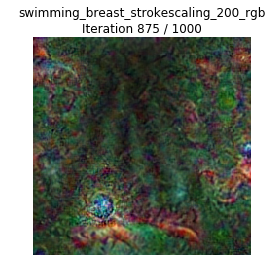

iteration: 875 288.836910963
iteration: 876 289.256950855
iteration: 877 289.535686016
iteration: 878 289.834120989
iteration: 879 290.270483971
iteration: 880 290.540485859
iteration: 881 290.831975937
iteration: 882 291.246412039
iteration: 883 291.508910894
iteration: 884 291.774775028
iteration: 885 292.159910917
iteration: 886 292.423038006
iteration: 887 292.689924002
iteration: 888 293.105862856
iteration: 889 293.376806021
iteration: 890 293.65805006
iteration: 891 294.072253942
iteration: 892 294.340044975
iteration: 893 294.608495951
iteration: 894 295.020349026
iteration: 895 295.287652016
iteration: 896 295.574336052
iteration: 897 295.990686893
iteration: 898 296.261231899
iteration: 899 296.555991888


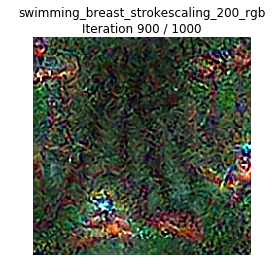

iteration: 900 297.029942989
iteration: 901 297.305080891
iteration: 902 297.635876894
iteration: 903 298.105552912
iteration: 904 298.378257036
iteration: 905 298.671242952
iteration: 906 299.102057934
iteration: 907 299.373106956
iteration: 908 299.662332058
iteration: 909 300.12531805
iteration: 910 300.405840874
iteration: 911 300.696698904
iteration: 912 301.146755934
iteration: 913 301.430933952
iteration: 914 301.751960039
iteration: 915 302.181516886
iteration: 916 302.462288857
iteration: 917 302.808918953
iteration: 918 303.270967007
iteration: 919 303.554708958
iteration: 920 303.898910046
iteration: 921 304.357110023
iteration: 922 304.632439852
iteration: 923 304.949163914
iteration: 924 305.450069904


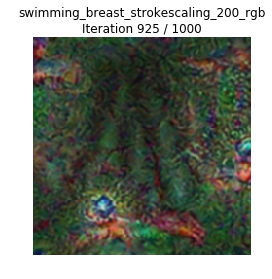

iteration: 925 305.917886972
iteration: 926 306.229264975
iteration: 927 306.630549908
iteration: 928 306.910501957
iteration: 929 307.231360912
iteration: 930 307.632611036
iteration: 931 307.906024933
iteration: 932 308.179328918
iteration: 933 308.563487053
iteration: 934 308.832424879
iteration: 935 309.107689857
iteration: 936 309.511976004
iteration: 937 309.784265995
iteration: 938 310.074339867
iteration: 939 310.477984905
iteration: 940 310.74296093
iteration: 941 311.01403594
iteration: 942 311.470898867
iteration: 943 311.748630047
iteration: 944 312.053001881
iteration: 945 312.529437065
iteration: 946 312.817258835
iteration: 947 313.161567926
iteration: 948 313.638358831
iteration: 949 313.913028002


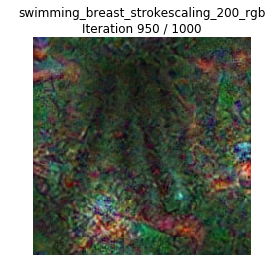

iteration: 950 314.289119005
iteration: 951 314.745053053
iteration: 952 315.038336992
iteration: 953 315.372318983
iteration: 954 315.809109926
iteration: 955 316.090044022
iteration: 956 316.414882898
iteration: 957 316.897727966
iteration: 958 317.182291985
iteration: 959 317.522073984
iteration: 960 317.997892857
iteration: 961 318.283004045
iteration: 962 318.621710062
iteration: 963 319.062334061
iteration: 964 319.33668685
iteration: 965 319.612058878
iteration: 966 319.974900961
iteration: 967 320.245898962
iteration: 968 320.539482832
iteration: 969 320.962020874
iteration: 970 321.250536919
iteration: 971 321.583930016
iteration: 972 322.029140949
iteration: 973 322.317070007
iteration: 974 322.672062874


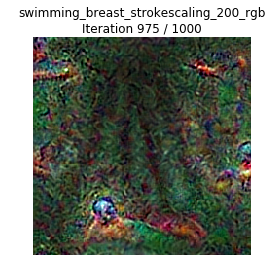

iteration: 975 323.265231848
iteration: 976 323.541976929
iteration: 977 323.813732862
iteration: 978 324.227148056
iteration: 979 324.499795914
iteration: 980 324.797044992
iteration: 981 325.183126926
iteration: 982 325.450604916
iteration: 983 325.734830856
iteration: 984 326.221120834
iteration: 985 326.515277863
iteration: 986 326.860662937
iteration: 987 327.325453997
iteration: 988 327.654253006
iteration: 989 327.977095842
iteration: 990 328.456022024
iteration: 991 328.732805967
iteration: 992 329.009991884
iteration: 993 329.396080017
iteration: 994 329.680556059
iteration: 995 330.016645908
iteration: 996 330.490429878
iteration: 997 330.782561064
iteration: 998 331.119569063
iteration: 999 331.584413052
file_name experiments_rgb/swimming_breast_strokescaling_200/swimming_breast_strokescaling_200_rgb{}.png


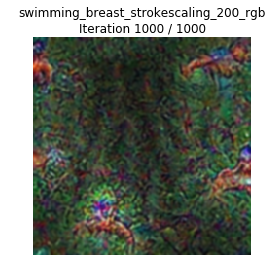

In [6]:
"""
Run RGB visualization only
"""
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print(model_logits)
print(rgb_input)
target = 340
print(kinetics_classes[target])
action_name = kinetics_classes[target].replace(" ", "_")
with tf.device("/gpu:0"):
    with tf.Session() as sess:
        # THIS LINE NEEDS TO BE MOVED
        rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb_imagenet'])
        # number of frames must be >= 9 or else kernel crashes
        rgb_visual_gif = create_class_visualization(sess, rgb_input, flow_input, target, rgb_logits, action_name + "scaling_200", 
                                   stream_type='rgb', num_frames=25, num_iterations=1000, learning_rate=1.5, 
                                   blur_every=3, max_jitter=32)

In [ ]:
"""
Run FLOW visualization only
"""
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
print(model_logits)
print(flow_input)
target = 171
print(kinetics_classes[target])
action_name = kinetics_classes[target].replace(" ", "_")
with tf.device("/gpu:0"):
    with tf.Session() as sess:
        # THIS LINE NEEDS TO BE MOVED
        flow_saver.restore(sess, _CHECKPOINT_PATHS['flow_imagenet'])
        flow_visual_gif = create_class_visualization(sess, rgb_input, flow_input, target, flow_logits, action_name + "test", stream_type='flow', num_frames=25, num_iterations=1000, l2_reg=1e-2, learning_rate=1.5, blur_every=10, max_jitter=32, sigma=.5)

In [ ]:
"""
Print all classes
"""
indexes = range(len(kinetics_classes))
class_to_index = dict(zip(kinetics_classes, indexes))
index_to_class = dict(zip(indexes, kinetics_classes))
print(index_to_class)

temp = np.append(0*np.ones((224, 224, 1)), -.205*np.ones((224, 224, 1)), axis=2)
plt.imshow(create_flow_image(temp))